# Placebo test

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
import pymc as pm
import arviz as az

rng = np.random.default_rng(42)
figsize = (10, 5)
az.style.use("arviz-darkgrid")

In [2]:
filepath = '../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

In [460]:
placebo_year_list = [1980, 1985, 1990, 1995]
pre_treatment_data = df[(df['after_treatment'] == 0) & (df['year'] >= 1970) & (df['year'] <= 2005)].copy()

for placebo_year in placebo_year_list:
    pre_treatment_data.loc[(pre_treatment_data['treatment_group'] == 0), f'placebo_treatment_{placebo_year}'] = 0
    pre_treatment_data.loc[(pre_treatment_data['year'] < placebo_year) & (pre_treatment_data['treatment_group'] == 1), f'placebo_treatment_{placebo_year}'] = 0
    pre_treatment_data.loc[(pre_treatment_data['year'] >= placebo_year) & (pre_treatment_data['treatment_group'] == 1), f'placebo_treatment_{placebo_year}'] = 1

df_ = pre_treatment_data.copy()
# 島ごとの平均人口
df_['log_pop_m_island'] = df_['log_pop'] - df_.groupby('island_ids')['log_pop'].transform('mean')
# 年ごとの平均人口
df_['log_pop_m_island_year'] = df_['log_pop_m_island'] - df_.groupby('year')['log_pop_m_island'].transform('mean')
# 戻す
pre_treatment_data['log_pop_star'] = df_['log_pop_m_island_year']

y_std_i = pre_treatment_data.groupby('island_ids')['log_pop_star'].std()

In [461]:
pre_treatment_data.describe()

,island_ids,year,pseudo_year,prefecture_codes,population,treatment_group,treatment_group_mainland,bridge_year,pseudo_bridge_year,after_treatment,...,distance_m,log_pop,pop_star,log_pop_star,time_since_treatment,is_already_treated,placebo_treatment_1980,placebo_treatment_1985,placebo_treatment_1990,placebo_treatment_1995
count,680.000000,680.000000,680.000000,680.000000,613.000000,680.000000,680.000000,680.000000,680.000000,680.0,...,680.000000,613.000000,613.000000,6.130000e+02,680.000000,680.0,680.000000,680.000000,680.000000,680.000000
mean,142.570588,1989.788235,1989.772059,35.622059,1036.882545,0.252941,0.211765,505.542647,505.526471,0.0,...,885.482382,5.374701,-99.706039,1.086678e-18,-3.798529,0.0,0.155882,0.119118,0.086765,0.063235
std,48.828675,12.255473,12.250074,1.968032,3137.616292,0.435018,0.408860,869.473640,869.445395,0.0,...,538.749582,1.747971,1024.172975,2.441807e-01,8.530410,0.0,0.363011,0.324165,0.281697,0.243565
min,67.000000,1970.000000,1969.000000,32.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,30.000000,1.609438,-9927.428986,-1.240336e+00,-48.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,101.000000,1980.000000,1980.000000,34.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,437.500000,3.951244,-336.651208,-1.390958e-01,-1.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,140.000000,1990.000000,1990.000000,35.000000,158.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,800.000000,5.062595,-49.478247,9.574039e-03,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,189.250000,2002.000000,2002.000000,38.000000,806.000000,1.000000,0.000000,1972.250000,1971.500000,0.0,...,1260.000000,6.692084,28.402144,1.281558e-01,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,221.000000,2005.000000,2005.000000,39.000000,44819.000000,1.000000,1.000000,2018.000000,2018.000000,0.0,...,1982.000000,10.710387,10446.571014,9.763114e-01,0.000000,0.0,1.000000,1.000000,1.000000,1.000000


<Axes: xlabel='log_pop', ylabel='Count'>

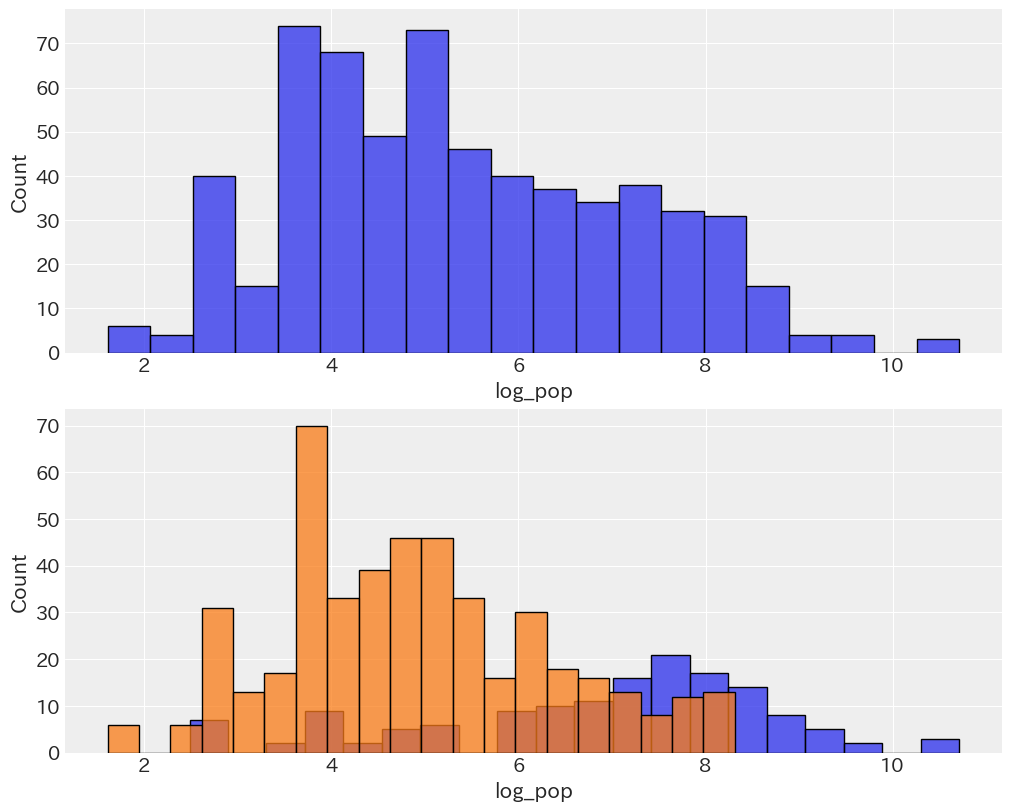

In [462]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sns.histplot(pre_treatment_data['log_pop'], bins=20, ax=ax[0])
sns.histplot(pre_treatment_data['log_pop'][pre_treatment_data['treatment_group'] == 1], bins=20, ax=ax[1])
sns.histplot(pre_treatment_data['log_pop'][pre_treatment_data['treatment_group'] == 0], bins=20, ax=ax[1])

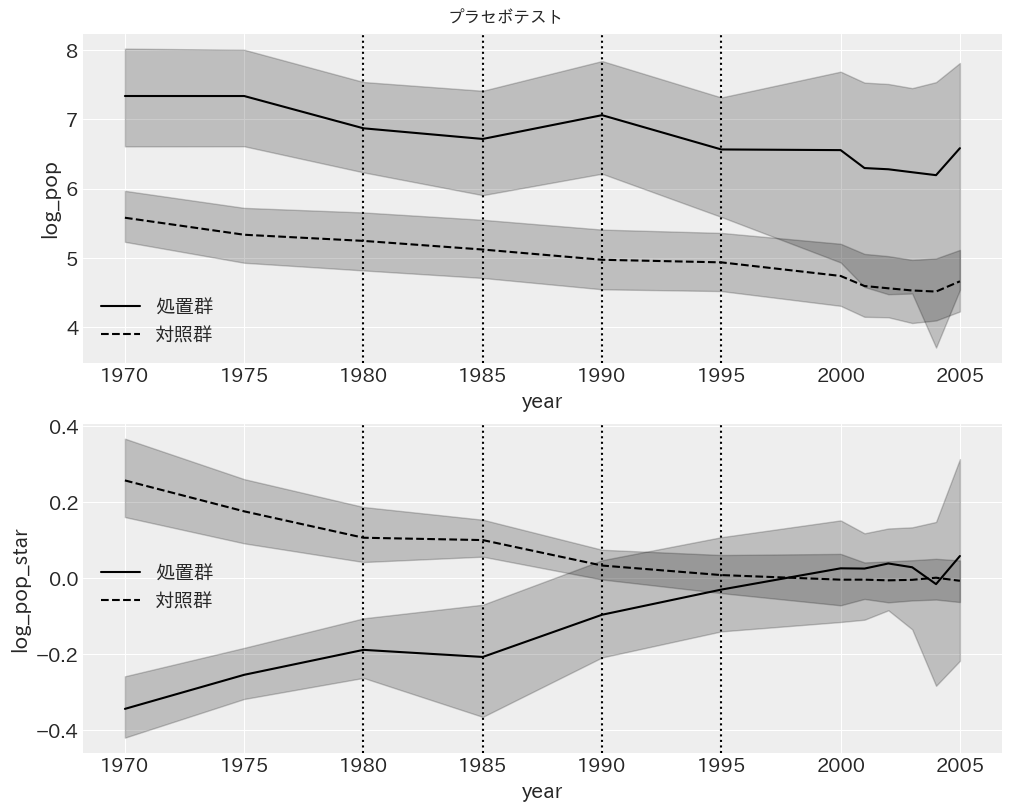

In [463]:
# プロットによる視覚化
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle('プラセボテスト')
sns.lineplot(data=pre_treatment_data[pre_treatment_data['treatment_group'] == 1], x='year', y='log_pop', label='処置群', ax=ax[0], color='black')
sns.lineplot(data=pre_treatment_data[pre_treatment_data['treatment_group'] == 0], x='year', y='log_pop', label='対照群', ax=ax[0], color='black', linestyle='--')
for placebo_year in placebo_year_list:
    ax[0].axvline(x=placebo_year, color='black', linestyle=':')
ax[0].legend()

sns.lineplot(data=pre_treatment_data[pre_treatment_data['treatment_group'] == 1], x='year', y='log_pop_star', label='処置群', ax=ax[1], color='black')
sns.lineplot(data=pre_treatment_data[pre_treatment_data['treatment_group'] == 0], x='year', y='log_pop_star', label='対照群', ax=ax[1], color='black', linestyle='--')
for placebo_year in placebo_year_list:
    ax[1].axvline(x=placebo_year, color='black', linestyle=':')
ax[1].legend()

plt.show()

## 頻度主義

In [464]:
placebo_effects = pd.DataFrame()

for placebo_year in placebo_year_list:
    formula = f'log_pop_star ~ placebo_treatment_{placebo_year}'
    y, X = dmatrices(formula, pre_treatment_data, return_type='dataframe')
    freaq_model = sm.OLS(y, X)
    result = freaq_model.fit(cov_type='HC1')
    # print(result.summary())
    summary_df = pd.DataFrame(result.summary().tables[1].data[1:], columns=result.summary().tables[1].data[0])
    summary_df['placebo_year'] = placebo_year
    placebo_effects = pd.concat([placebo_effects, summary_df])

In [465]:
placebo_effects.drop(index=0, inplace=True)

In [466]:
placebo_effects.reset_index(drop=True)
placebo_effects['placebo_year'] = placebo_effects['placebo_year'].astype(str)
placebo_effects.set_index('placebo_year', inplace=True)
placebo_effects.drop(columns=[''], inplace=True)
placebo_effects['coef'] = placebo_effects['coef'].astype(float)
placebo_effects['std err'] = placebo_effects['std err'].astype(float)
placebo_effects['z'] = placebo_effects['z'].astype(float)
placebo_effects['P>|z|'] = placebo_effects['P>|z|'].astype(float)
placebo_effects['[0.025'] = placebo_effects['[0.025'].astype(float)
placebo_effects['0.975]'] = placebo_effects['0.975]'].astype(float)
placebo_effects

,coef,std err,z,P>|z|,[0.025,0.975]
placebo_year,,,,,,
1980,-0.1052,0.028,-3.743,0.000,-0.160,-0.050
1985,-0.0690,0.032,-2.140,0.032,-0.132,-0.006
1990,-0.0151,0.031,-0.492,0.623,-0.075,0.045
1995,0.0119,0.033,0.362,0.718,-0.052,0.076


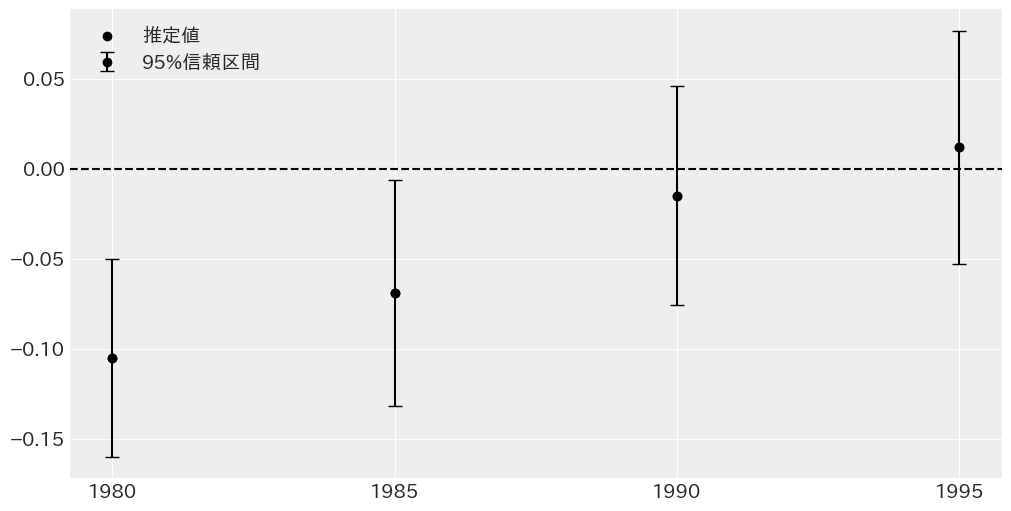

In [467]:
fig, ax = plt.subplots(figsize=figsize)
ax.scatter(placebo_effects.index, placebo_effects['coef'], color='black', label='推定値')
ax.errorbar(
    x=placebo_effects.index,
    y=placebo_effects['coef'],
    yerr=1.96 * placebo_effects['std err'],
    fmt='o',
    color='black',
    capsize=5,
    label='95%信頼区間',
)
ax.legend()
ax.axhline(y=0, color='black', linestyle='--')

# Bayes

In [106]:
island_ids, unique_island_ids = pd.factorize(pre_treatment_data['island_ids'])
n_islands = len(unique_island_ids)

with pm.Model() as model:
    model.add_coords({'obs_id': np.arange(len(pre_treatment_data))})

    # data
    # island_ids = pm.Data('island_ids', island_ids)

    # prior
    beta = pm.Normal('beta', mu=0, sigma=0.1)
    sigma = pm.HalfCauchy('sigma', beta=0.15)
    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    # likelihood
    mu = beta * pre_treatment_data['placebo_treatment']
    y = pm.StudentT('y', mu=mu, sigma=sigma, nu=nu, observed=pre_treatment_data['log_pop_star'], dims='obs_id')

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


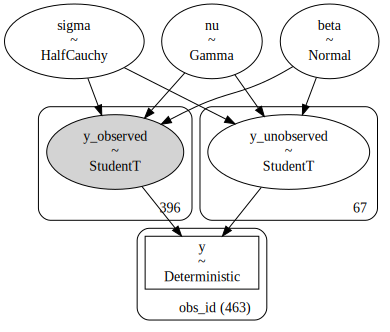

In [107]:
pm.model_to_graphviz(model)

In [108]:
with model:
    trace = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=rng
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [110]:
az.summary(trace, var_names=['beta', 'sigma', 'nu'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.018,0.024,-0.026,0.066,0.000,0.000,15674.0,6321.0,1.0
sigma,0.164,0.012,0.142,0.186,0.000,0.000,5966.0,5508.0,1.0
nu,4.715,1.407,2.580,7.265,0.018,0.013,6194.0,5760.0,1.0


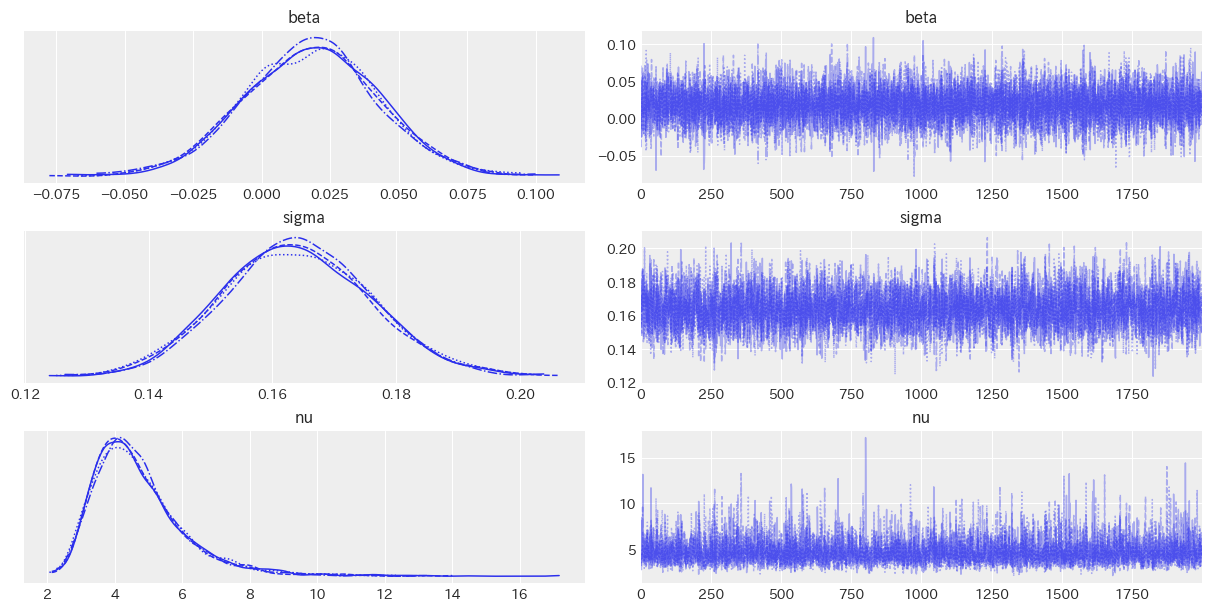

In [112]:
az.plot_trace(trace, var_names=['beta', 'sigma', 'nu']);

<Axes: title={'center': 'beta'}>

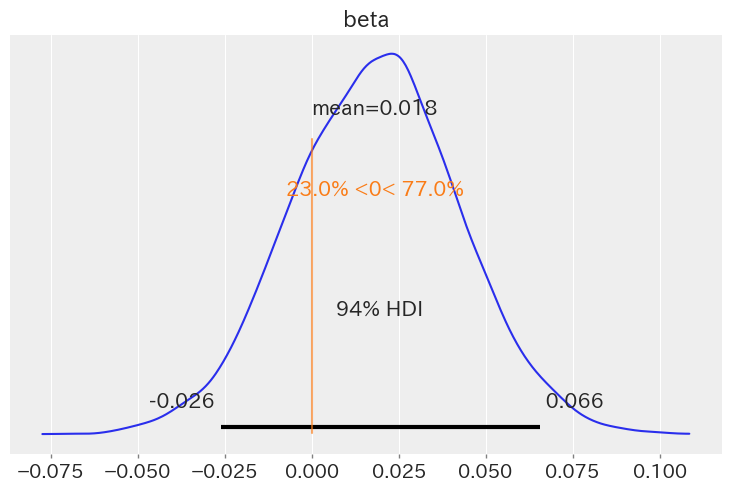

In [114]:
az.plot_posterior(trace, var_names=['beta'], ref_val=0)

In [115]:
with model:
    pm.compute_log_likelihood(trace)

Output()

In [116]:
az.waic(trace)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 posterior samples and 396 observations log-likelihood matrix.

          Estimate       SE
elpd_waic    56.97    19.41
p_waic        3.11        -

There has been a warning during the calculation. Please check the results.